In [1]:
import copy

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import get_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)

/home/renzo/anaconda3/envs/dl-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problem Definition

## Dataset
LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

Section contents:
- Visualize random sample
- Calculate dataset statistics

In [2]:
dataset_name = "librispeech"
url = 'train-clean-100'
dataset = get_dataset(dataset_name, url=url)

You're about to download librispeech with url train-clean-100

 Done downloading


#### Visualizing data in random sample

In [3]:
# visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [4]:
# waveform_lengths = []
# sample_rates = []
# transcript_lengths = []
# speaker_ids = []
# audio_durations = []
# waveforms = []
# transcripts = []

# for i in tqdm(range(dataset.__len__())):
#     (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
#     speaker_ids.append(speaker_id)

    # waveform_lengths.append(waveform[0].shape[0])
    # sample_rates.append(sample_rate)
    # transcript_lengths.append(len(transcript))
    # waveforms.append(waveform[0].numpy())
    # transcripts.append(transcript)

    # num_channels, num_frames = waveform.shape
    # duration = num_frames / sample_rate
    # audio_durations.append(duration)

# dataset_stats = pd.DataFrame.from_dict(
# {
#     "waveform_lengths" : waveform_lengths,
#     "sample_rates" : sample_rates,
#     "transcript_lengths" : transcript_lengths,
#     "audio_durations" : audio_durations,
# }
#     )

In [5]:
# df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
# df_spkr['speaker_id'] = speaker_ids
# # df_spkr['duration'] = audio_durations

In [6]:
# df_spkr.to_csv('df_speaker_ids.csv')

In [3]:
df_spkr = pd.read_csv('df_speaker_ids.csv')

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset

In [8]:
# df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

Number of samples for each speaker

In [9]:
# df_spkr.groupby('speaker_id').size().sort_values()

In [10]:
# df = calculate_statistics(dataset)

Unique speaker ids

In [12]:
# np.unique(df_spkr['speaker_id'])

Visualize spectrograms

In [ ]:
# df_speaker_waveform = pd.DataFrame(columns=['speaker_id', 'waveform', 'transcript'])
# df_speaker_waveform['speaker_id'] = speaker_ids
# df_speaker_waveform['waveform'] = waveforms
# df_speaker_waveform['transcript'] = transcripts

In [ ]:
# df_speaker_waveform[df_speaker_waveform['speaker_id']==84].head()

In [ ]:
# num_cols = 3
# for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
#     fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
#     waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
#     idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
#     for j, wave in enumerate(waves[:num_cols]):
#         ax[j].specgram(wave, Fs=sample_rate)
#         ax[j].set_title(f'speaker {speaker_id}, df.index: {idx[j]}')

#         plt.tight_layout()

Visualize MFCC spectrograms

In [ ]:
# num_cols = 3
# for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
#     fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
#     waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
#     idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
#     for j, wave in enumerate(waves[:num_cols]):
#         mfccs = librosa.feature.mfcc(y=wave.flatten(), n_mfcc=13, sr=sample_rate)
#         img = librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate, ax=ax[j])
#         ax[j].set_title(f'speaker: {speaker_id}, df.index: {idx[j]}')
#         fig.colorbar(img, ax=ax[j], format="%+2.f dB")
#     plt.tight_layout()

## Preprocessing

We decided to normalize our data by using the mean and variance of the amplitude. The normalizer is fitted on the whole training set, not for each speaker. The reasoning for this is that in our problem, we do not know ahead of time who the speaker is.

In [4]:
def speaker_encoder(speaker_ids):
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
        
    return speaker_dict

In [5]:
def create_mfcc_databases(dataset, window_size : int, sample_rate : int, speaker_dict : dict, number_spectral_coefficients : int):
    """
    Creates two databases from an audio dataset e.g. librispeech
    
    Returns
    -------
    speaker_mfcc_db : pd.DataFrame 
        df with shape (index_id, speaker_id, mfcc_id)
    
    mfcc_channel_db : pd.DataFrame
        df with shape (mfcc_id, channel_id)
    
    """
    try:
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
    
    except FileNotFoundError:
        speaker_mfcc_db = pd.DataFrame(columns=["speaker_id", "mfcc_id"])
        mfcc_channel_db = pd.DataFrame(columns=["mfcc_id"]+[f"channel_{i}" for i in range(number_spectral_coefficients)]).set_index('mfcc_id')

        idx = 0

        print('Creating a database. Hold tight...')
        for i in tqdm(range(dataset.__len__())):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, window_size) # split waveforms into consistent chunks

            for chunk in splitted_waveform: # transform waveforms into MFCC spectrograms
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=sample_rate)

                speaker_mfcc_db.loc[idx, "speaker_id"] = speaker_dict[speaker_id]
                speaker_mfcc_db.loc[idx, "mfcc_id"] = idx

                for j in range(number_spectral_coefficients):
                    mfcc_channel_db.loc[idx, f"channel_{j}"] = 1
                    mfcc_channel_db.at[idx, f"channel_{j}"] = mfccs[j, :]
                
                idx += 1

        speaker_mfcc_db.to_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db.to_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')

    return speaker_mfcc_db, mfcc_channel_db

In [6]:
def get_datasets(base_dataset, speaker_dict : dict, window_size : int, sample_rate : int, train_pct : float, 
                 val_pct : float, test_pct : float, number_spectral_coefficients : int, cepstral_normalize : bool, transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset

    """
    speaker_mfcc_db, mfcc_channel_db = create_mfcc_databases(base_dataset, window_size=window_size, sample_rate=sample_rate, speaker_dict=speaker_dict, number_spectral_coefficients=number_spectral_coefficients)

    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)
    
    torch.save(mfcc_dataset_train, 'mfcc_dataset_train.pt')
    torch.save(mfcc_dataset_val, 'mfcc_dataset_val.pt')
    torch.save(mfcc_dataset_test, 'mfcc_dataset_test.pt')

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [7]:
def split_waveform(waveform : np.array, window_size : int) -> list[np.array]:
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waverforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform


class CepstralNormalization:
    def __init__(self, number_spectral_coefficients : int):
        """
        """
        self.number_spectral_coefficients = number_spectral_coefficients
        self.mfcc_mean : list[float] | None = None
        self.mfcc_std : list[float] | None = None
    
    def fit(self, mfcc_ids, mfcc_channel_db):
        """
        """
        mfcc_mean = []
        mfcc_std = []
        
        print('Normalizing...')
        for channel in tqdm(range(self.number_spectral_coefficients)):
            channel_data = mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"].values
            channel_data_list = []
            for x in channel_data:
                channel_data_list.extend(x.flatten().tolist())
            
            mfcc_mean.append(np.mean(channel_data_list))
            mfcc_std.append(np.std(channel_data_list))

        self.mfcc_mean, self.mfcc_std = mfcc_mean, mfcc_std
        
        return self.mfcc_mean, self.mfcc_std
    
    def transform(self, mfcc_ids, mfcc_channel_db):
        """
        """                
        for channel in range(self.number_spectral_coefficients):
            channel_data = mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"].values
            channel_data = (channel_data - self.mfcc_mean[channel]) / self.mfcc_std[channel]
            
            mfcc_channel_db.loc[mfcc_ids][f"channel_{channel}"] = channel_data
                
        return mfcc_channel_db

def array_to_image_transform(mfcc_arr):
    mfcc_img = Image.fromarray(mfcc_arr, mode='L')
    mfcc_img = np.array(mfcc_img)
    return mfcc_img

In [8]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        train_test_val : str
            one of 'train', 'validation', or 'test'
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = array_to_image_transform(mfcc)
            mfcc = self.transform(mfcc)
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [9]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct):
    """
    Samples from each speaker_id must be included in each: train, val, test
    
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:int(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[int(len_ids * train_pct):int(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[int(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [22]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 50

train_pct = 0.70
val_pct = 0.20
test_pct = 0.10
number_spectral_coefficients = 13
cepstral_normalize = True

custom_transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
speaker_dict = speaker_encoder(np.unique(df_spkr['speaker_id']))
# mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(dataset, 
#                                                 speaker_dict=speaker_dict,
#                                                 window_size=window_size, 
#                                                 sample_rate=sample_rate, 
#                                                 train_pct=train_pct,
#                                                 val_pct=val_pct,
#                                                 test_pct=test_pct,
#                                                 number_spectral_coefficients=number_spectral_coefficients,
#                                                 cepstral_normalize=cepstral_normalize,
#                                                 transform=custom_transform,
#                                                 )

In [23]:
mfcc_dataset_train = torch.load('mfcc_dataset_train.pt')
mfcc_dataset_val = torch.load('mfcc_dataset_val.pt')
mfcc_dataset_test = torch.load('mfcc_dataset_test.pt')

In [24]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [13]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(), 

(52097, 14909, 7584)

In [14]:
sample_mfcc, sample_speaker = mfcc_dataset_train.__getitem__(0)
sample_mfcc.shape, sample_speaker.shape

/tmp/ipykernel_12883/3454332804.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


(torch.Size([1, 13, 126]), torch.Size([]))

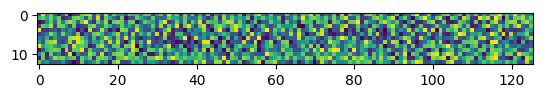

In [15]:
plt.imshow(np.transpose(sample_mfcc.to('cpu').numpy(), [1, 2, 0]))

## Model Training

In [16]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    val_acc = []

    for i, data in enumerate(loader, 0):
        mfcc, speakers = data
        outputs = model(mfcc)
        
        loss = criterion(outputs, speakers)
        total_loss += loss.item()
        total_epoch += len(speakers)
        val_acc.append(get_accuracy(output=outputs, mfcc=mfcc, speakers=speakers))
        
    loss = float(total_loss) / (i + 1)
    val_acc = np.mean(val_acc)
    return loss, val_acc

def get_accuracy(output, mfcc, speakers):
    #select index with maximum prediction score
    correct = 0
    total = 0
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(speakers.view_as(pred)).sum().item()
    total += mfcc.shape[0]
    return correct / total

def train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2, plot_loss=True):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
        
    if torch.cuda.is_available():
        model = model.to(torch.device('cuda:0'))
    
    for epoch in range(num_epochs): 
        total_train_loss = 0.0
        total_epoch = 0
        total_train_acc = []
        correct = 0.0
        total = 0.0
        
        for i, data in enumerate(train_loader):
            mfcc, speakers = data
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = model(mfcc)
            loss = criterion(outputs, speakers)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(speakers)
            total_train_acc.append(get_accuracy(output=outputs, mfcc=mfcc, speakers=speakers))
            
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_acc[epoch] = np.mean(total_train_acc)        
        val_loss[epoch], val_acc[epoch] = evaluate(model, val_loader, criterion)
        
        if epoch % print_every == 0:    
            print(f"Epoch {epoch}: \n \
            Train loss {train_loss[epoch]:.3f} | Val loss {val_loss[epoch]:.3f} \n \
            Train acc {train_acc[epoch]:.3f} | Val acc {val_acc[epoch]:.3f} \n")
            
            
    if plot_loss:
        n = len(train_loss) # number of epochs
        plt.figure()
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,n+1), train_loss, label="Train")
        plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        # plt.show()

        plt.figure()
        plt.title("Train vs Validation Accuracy")
        plt.plot(range(1,n+1), train_acc, label="Train")
        plt.plot(range(1,n+1), val_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')   

In [17]:
class FCN(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_size):
        super(FCN, self).__init__()

        self.fc1 = nn.Linear(3 * 11 * 124, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = x.view(-1, 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
class CNN(nn.Module):
    def __init__(self, hidden_layers, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(1 * 13 * 126, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(-1, 1 * 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
# model hyperparameters
hidden_layers = 100
output_size = 40
lr = 0.01
momentum = 0.9
num_epochs = 30

model = CNN(hidden_layers=hidden_layers, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
num_epochs = num_epochs

In [26]:
train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')

In [ ]:
test_model(model, test_loader)

In [ ]:
for mfcc, speakers in test_loader:
    outputs = model(mfcc)
    _, predicted = torch.max(outputs.data, 1)
    print(f"predicted: {predicted}, actual: {speakers}")

## AlexNet

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(11,11), stride=(4,4), padding=(2,2))

In [ ]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [ ]:
#Modify the final output layer

alexnet.classifier[6] = nn.Linear(4096, 500)
alexnet.classifier[7] = nn.LeakyReLU()
alexnet.classifier[8] = nn.Linear(500, 40)
alexnet.classifier.add_module("9", nn.LogSoftmax(dim = 1))
alexnet

In [ ]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(alexnet.parameters())


def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/2399 
        avg_train_acc = train_acc/2399

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/686 
        avg_valid_acc = valid_acc/686

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
import time

In [ ]:
alexnet = alexnet.to('cuda')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 20
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tacc, vacc, tloss, vloss in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


In [ ]:
n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [ ]:
for mfcc, speakers in train_loader:
    break

In [ ]:
plt.imshow(np.transpose(mfcc[0].to('cpu').numpy(), [1, 2, 0]))